# SECTION-A: Python & Data Cleaning

## 1. Load Dataset and Review Data Structure, Types, and Missing Values


In [1]:
import pandas as pd
df = pd.read_csv("crop_yield.csv")  
print(df.info())
print(df.head())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             19689 non-null  object 
 1   Crop_Year        19689 non-null  int64  
 2   Season           19689 non-null  object 
 3   State            19689 non-null  object 
 4   Area             19689 non-null  float64
 5   Production       19689 non-null  int64  
 6   Annual_Rainfall  19689 non-null  float64
 7   Fertilizer       19689 non-null  float64
 8   Pesticide        19689 non-null  float64
 9   Yield            19689 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.5+ MB
None
           Crop  Crop_Year       Season  State     Area  Production  \
0      Arecanut       1997  Whole Year   Assam  73814.0       56708   
1     Arhar/Tur       1997  Kharif       Assam   6637.0        4685   
2   Castor seed       1997  Kharif       Assam    796.0    

#### Explanation:
- pd.read_csv() loads your data into a DataFrame.
- info() shows data types, null counts.
- head() shows first few records.
- isnull().sum() shows how many missing values exist in each column.

## 2. Standardize Crop Names and State/District Names


In [2]:
df['Crop'] = df['Crop'].str.strip().str.title()
df['State'] = df['State'].str.strip().str.title()
df['Season'] = df['Season'].str.strip().str.title()


#### Explanation:
- str.strip() removes extra spaces.
- str.title() capitalizes first letters (e.g., cotton → Cotton).
- Without this, same value with different casing/spaces would be treated separately.

## 3. Handle Missing or Anomalous Production or Area Values


In [3]:
df = df[(df['Area'] > 0) & (df['Production'] >= 0)]

In [4]:
# Calculate 99th percentile thresholds
area_limit = df['Area'].quantile(0.99)
production_limit = df['Production'].quantile(0.99)

# Filter out rows above these limits
df = df[(df['Area'] <= area_limit) & (df['Production'] <= production_limit)]


#### Explanation:
- A crop grown on 0 area or with negative production makes no sense.
- These rows are filtered out for accurate analysis.

## 4. Create Derived Columns


## a. Yield = Production / Area


In [5]:
df['Computed_Yield'] = df['Production'] / df['Area']

In [6]:
# If the original 'Yield' is different from computed by more than 0.01
diff = (df['Yield'] - df['Computed_Yield']).abs()
df.loc[diff > 0.01, 'Yield'] = df['Computed_Yield']


## b. Production per Season per State aggregated annually


In [7]:
seasonal_production = df.groupby(['Crop_Year', 'State', 'Season'])['Production'].sum().reset_index()
print(seasonal_production.head())


   Crop_Year              State      Season  Production
0       1997     Andhra Pradesh      Kharif    23726800
1       1997     Andhra Pradesh        Rabi     4825800
2       1997  Arunachal Pradesh      Kharif      201675
3       1997  Arunachal Pradesh        Rabi       41183
4       1997  Arunachal Pradesh  Whole Year       24290


#### Explanation:
- This groups data by year + state + season and adds up the production.
- Helps in analyzing how much a state produced during each season of the year.

## c. Year-over-Year (YoY) Change in Production and Yield


In [8]:
# Sort by state, crop, and year
df.sort_values(by=['State', 'Crop', 'Crop_Year'], inplace=True)

# Calculate % change from previous year
df['Production_YoY_%'] = df.groupby(['State', 'Crop'])['Production'].pct_change() * 100
df['Yield_YoY_%'] = df.groupby(['State', 'Crop'])['Yield'].pct_change() * 100


#### Explanation:
- % change = ((this year - last year) / last year) × 100
- Helps in understanding growth or decline trends over time

## 5. Final Sample Output

In [9]:
df[['Crop_Year', 'State', 'Crop', 'Season', 'Area', 'Production', 'Yield', 'Production_YoY_%', 'Yield_YoY_%']].head()


,Crop_Year,State,Crop,Season,Area,Production,Yield,Production_YoY_%,Yield_YoY_%
490,2000,Andhra Pradesh,Arecanut,Whole Year,262.0,724,2.763359,NaN,NaN
757,2001,Andhra Pradesh,Arecanut,Whole Year,268.0,449,1.675373,-37.983425,-39.371856
1014,2002,Andhra Pradesh,Arecanut,Whole Year,296.0,427,1.452500,-4.899777,-13.302895
1220,2003,Andhra Pradesh,Arecanut,Whole Year,311.0,221,0.704000,-48.243560,-51.531842
1666,2005,Andhra Pradesh,Arecanut,Whole Year,293.0,234,0.802500,5.882353,13.991477


## Summary


| Step | Task                 | Output                        |
| ---- | -------------------- | ----------------------------- |
| 1    | Load and review      | Structure and missing info    |
| 2    | Standardize names    | Uniform Crop, State, Season   |
| 3    | Handle anomalies     | Remove zero/negative/outliers |
| 4a   | Yield = Prod / Area  | Derived or corrected          |
| 4b   | Prod by Season+State | Grouped & summarized          |
| 4c   | YoY % changes        | Growth/decline detection      |


# SECTION B: SQL Operations 

### Import cleaned data into SQLite or pandasql:

- CREATE DATABASE Cleaned_crop_yield;
- USE Cleaned_crop_yield;
- SELECT * FROM cleaned_crop_yield;

### 1. Identify top 5 crops by average yield per state

SELECT *

FROM (
    
    SELECT 
        State,
        Crop,
        AVG(Yield) AS avg_yield,
        ROW_NUMBER() OVER (PARTITION BY State ORDER BY AVG(Yield) DESC) AS ranking
    FROM cleaned_crop_yield
    GROUP BY State, Crop
) ranked
WHERE ranking <= 5
ORDER BY State, avg_yield DESC;

#### Output:
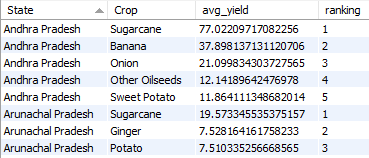


### 2. List states with highest production growth between 2010 and 2020

SELECT 
    
    State,
    SUM(CASE WHEN Crop_Year = 2010 THEN Production ELSE 0 END) AS production_2010,
    SUM(CASE WHEN Crop_Year = 2020 THEN Production ELSE 0 END) AS production_2020,
    ((SUM(CASE WHEN Crop_Year = 2020 THEN Production ELSE 0 END) -
      SUM(CASE WHEN Crop_Year = 2010 THEN Production ELSE 0 END))
      / SUM(CASE WHEN Crop_Year = 2010 THEN Production ELSE 0 END) * 100) AS growth_percent
FROM cleaned_crop_yield
GROUP BY State
ORDER BY growth_percent DESC;

#### Output:
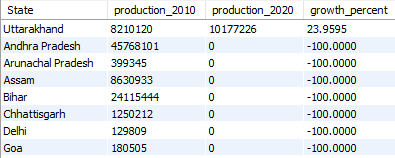

### 3. Rank districts by production consistency (low variance)

SELECT 
    
    State,
    VARIANCE(Production) AS production_variance
FROM cleaned_crop_yield
GROUP BY State
ORDER BY production_variance ASC;


#### Output:
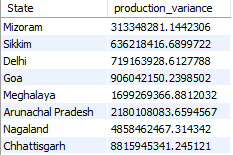

### 4. Query state-season combinations with highest yield
SELECT 
   
    State,
    Season,
    AVG(Yield) AS avg_yield
FROM cleaned_crop_yield
GROUP BY State, Season
ORDER BY avg_yield DESC
LIMIT 10;

#### Output:
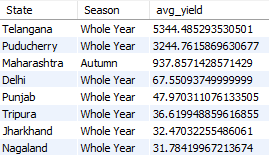

### 5. Compare yield between seasons (Kharif vs Rabi) for a specific crop

SELECT Season, AVG(Yield) AS avg_yield

FROM cleaned_crop_yield

WHERE Crop = 'Rice'
  
  AND Season IN ('Kharif', 'Rabi')

GROUP BY Season


#### Output:
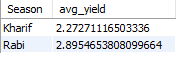

# SECTION C: EDA & Descriptive Statistics

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display first few rows
df.head()


,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield,Computed_Yield,Production_YoY_%,Yield_YoY_%
490,Arecanut,2000,Whole Year,Andhra Pradesh,262.0,724,935.6,25720.54,68.12,2.763359,2.763359,NaN,NaN
757,Arecanut,2001,Whole Year,Andhra Pradesh,268.0,449,928.4,27370.84,69.68,1.675373,1.675373,-37.983425,-39.371856
1014,Arecanut,2002,Whole Year,Andhra Pradesh,296.0,427,648.1,28022.32,74.00,1.452500,1.442568,-4.899777,-13.302895
1220,Arecanut,2003,Whole Year,Andhra Pradesh,311.0,221,826.0,30782.78,74.64,0.704000,0.710611,-48.243560,-51.531842
1666,Arecanut,2005,Whole Year,Andhra Pradesh,293.0,234,1075.5,35136.56,61.53,0.802500,0.798635,5.882353,13.991477


### Explanation:
Imported libraries for plotting and loaded the dataset.

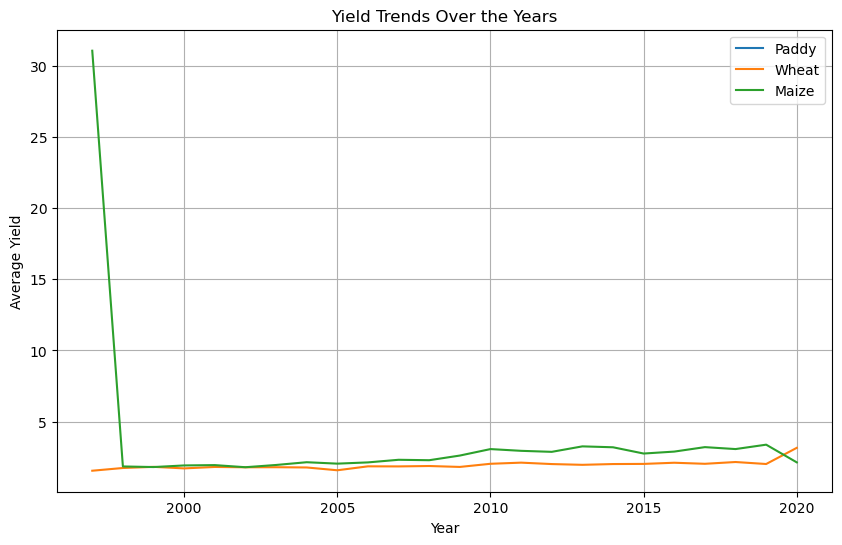

In [11]:
plt.figure(figsize=(10,6))
major_crops = ['Paddy', 'Wheat', 'Maize']
for crop in major_crops:
    crop_data = df[df['Crop'] == crop].groupby('Crop_Year')['Yield'].mean()
    plt.plot(crop_data.index, crop_data.values, label=crop)

plt.title("Yield Trends Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Yield")
plt.legend()
plt.grid(True)
plt.show()
#Line plot shows how yield is changing year-wise for paddy, wheat, and maize.

## Bar chart – State-wise total production per crop

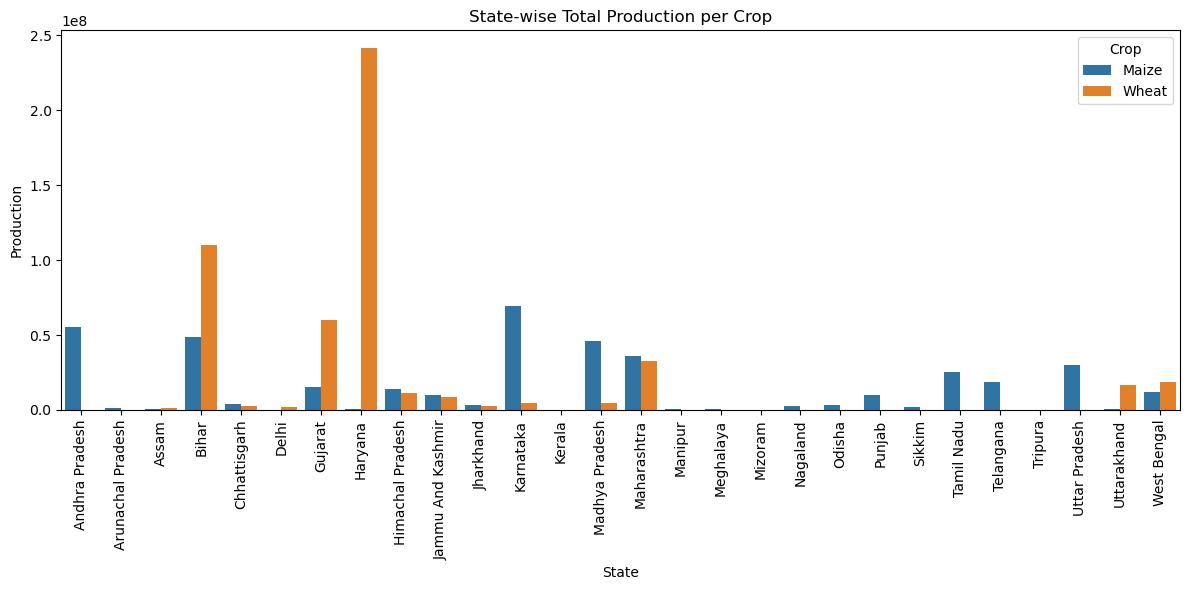

In [12]:
plt.figure(figsize=(12,6))
top_crop = df[df['Crop'].isin(major_crops)]
grouped = top_crop.groupby(['State', 'Crop'])['Production'].sum().reset_index()

sns.barplot(x='State', y='Production', hue='Crop', data=grouped)
plt.xticks(rotation=90)
plt.title("State-wise Total Production per Crop")
plt.tight_layout()
plt.show()
#Bar chart compares how much each major crop is produced in every state.

## Boxplot – Yield across seasons and crops

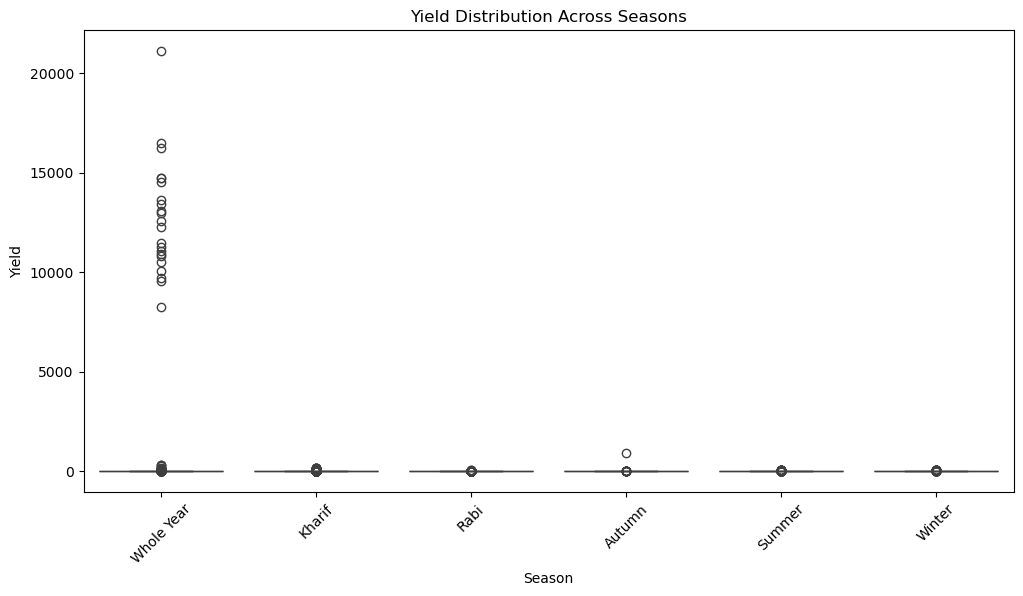

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Season', y='Yield', data=df)
plt.title("Yield Distribution Across Seasons")
plt.xticks(rotation=45)
plt.show()
#Boxplot helps us understand variability and outliers in yield across different seasons.

## Heatmap – Average yield by state and crop

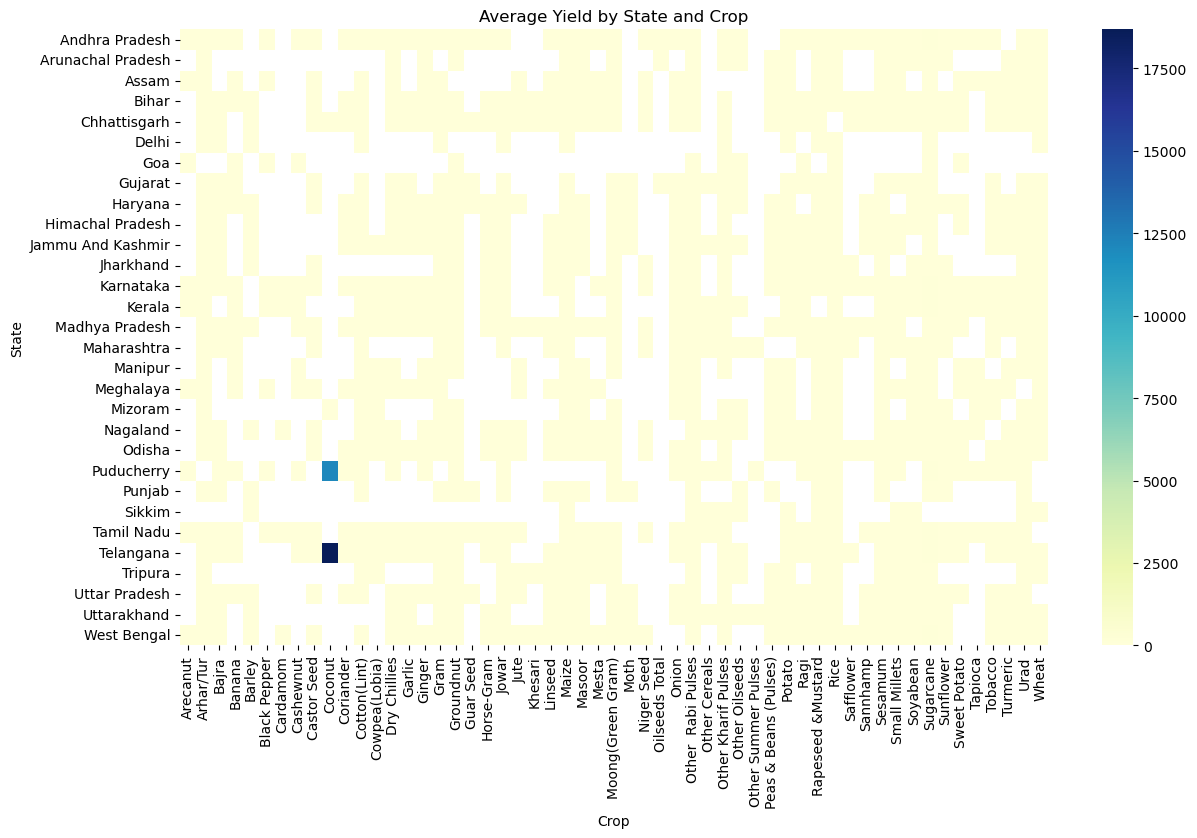

In [14]:
pivot_data = df.pivot_table(index='State', columns='Crop', values='Yield', aggfunc='mean')
plt.figure(figsize=(14,8))
sns.heatmap(pivot_data, cmap='YlGnBu')
plt.title("Average Yield by State and Crop")
plt.show()
#Heatmap shows how yield differs by crop across states. Darker = higher yield.

## Scatter plot – Production vs Area (with crop labels)

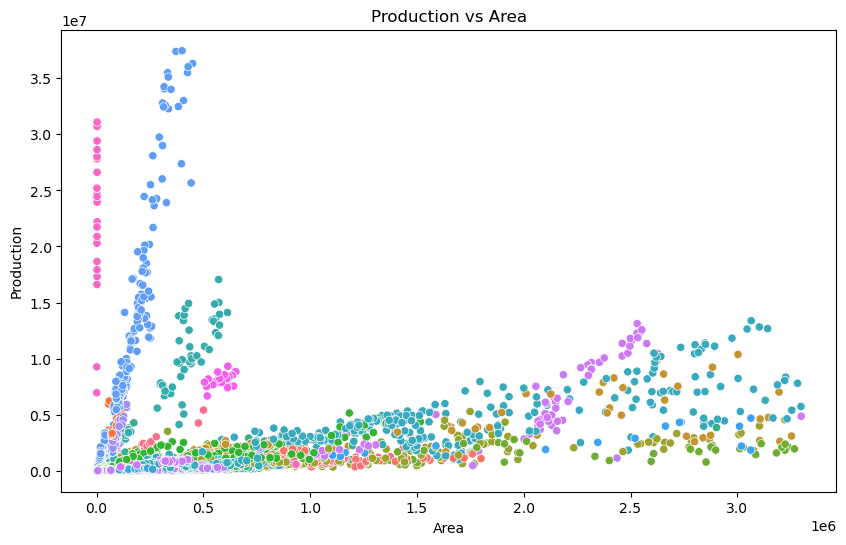

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Area', y='Production', hue='Crop', data=df, legend=False)
plt.title("Production vs Area")
plt.xlabel("Area")
plt.ylabel("Production")
plt.show()
#Scatter plot to check the relationship between area and production.

## Yield & Production comparison between Kharif & Rabi

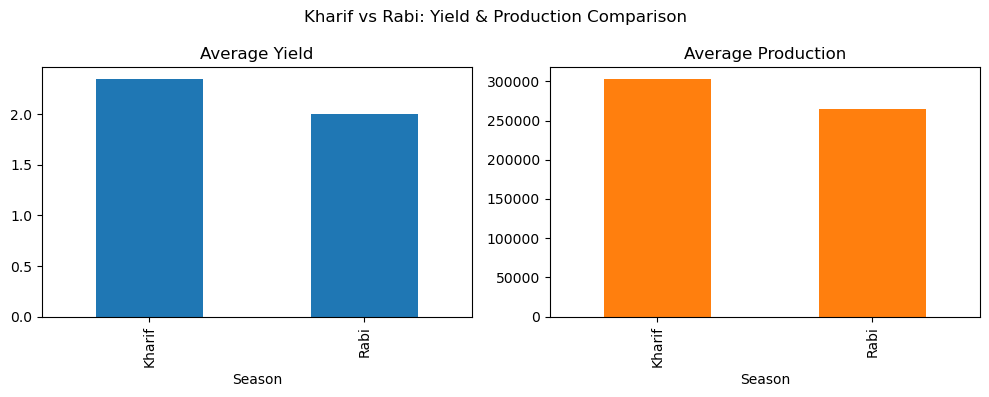

In [16]:
seasonal = df[df['Season'].isin(['Kharif', 'Rabi'])].groupby('Season')[['Yield', 'Production']].mean()
seasonal.plot(kind='bar', subplots=True, layout=(1, 2), figsize=(10, 4), title=['Average Yield', 'Average Production'], legend=False)
plt.suptitle("Kharif vs Rabi: Yield & Production Comparison")
plt.tight_layout()
plt.show()
#Shows which season is more productive overall – Kharif or Rabi.

## Variability (Std Dev) of yield per state over time

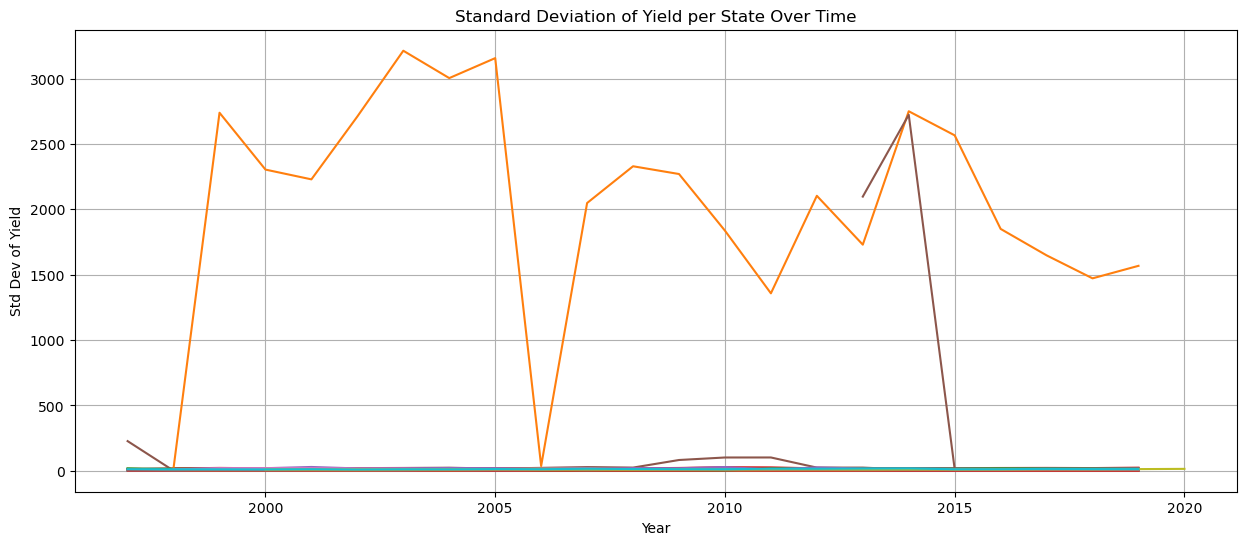

In [17]:
variability = df.groupby(['State', 'Crop_Year'])['Yield'].std().unstack()
variability.T.plot(figsize=(15,6), legend=False)
plt.title("Standard Deviation of Yield per State Over Time")
plt.xlabel("Year")
plt.ylabel("Std Dev of Yield")
plt.grid(True)
plt.show()
#This plot shows yield consistency (or variability) across states over years.

# Descriptive Statistics Section

## Basic stats – mean, median, variance, std dev

In [18]:
desc = df[['Yield', 'Production']].agg(['mean', 'median', 'var', 'std'])
desc
#Table showing key descriptive stats for yield and production.

,Yield,Production
mean,18.814750,4.274216e+05
median,1.015518,1.257900e+04
var,193013.968058,3.940834e+12
std,439.333550,1.985153e+06


## Coefficient of Variation for yield

In [19]:
cv = df.groupby(['State', 'Crop'])['Yield'].agg(['mean', 'std']).reset_index()
cv['CV (%)'] = (cv['std'] / cv['mean']) * 100
cv[['State', 'Crop', 'CV (%)']].sort_values(by='CV (%)')
#Coefficient of Variation (CV) shows variability in yield. Lower CV = more consistent.

,State,Crop,CV (%)
539,Manipur,Jute,0.000000
652,Nagaland,Turmeric,0.000000
186,Delhi,Cotton(Lint),0.000000
732,Punjab,Jowar,0.000000
660,Odisha,Cowpea(Lobia),0.086631
...,...,...,...
892,Uttar Pradesh,Other Kharif Pulses,NaN
902,Uttar Pradesh,Sugarcane,NaN
911,Uttarakhand,Dry Chillies,NaN
933,Uttarakhand,Sannhamp,NaN


## Top 3 crops with lowest yield variability

In [20]:
lowest_cv = cv.groupby('Crop')['CV (%)'].mean().sort_values().head(3)
lowest_cv
#these are the most stable crops in terms of yield.

Crop
Niger Seed    16.182328
Ragi          17.228447
Coconut       17.880267
Name: CV (%), dtype: float64

## Outliers in Yield using IQR

In [21]:
Q1 = df['Yield'].quantile(0.25)
Q3 = df['Yield'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['Yield'] < Q1 - 1.5 * IQR) | (df['Yield'] > Q3 + 1.5 * IQR)]
outliers[['State', 'Season', 'Yield']].head()
#Shows states or seasons with extreme low/high yield.

,State,Season,Yield
5069,Andhra Pradesh,Kharif,6.268293
5416,Andhra Pradesh,Kharif,5.447746
5761,Andhra Pradesh,Kharif,9.505474
495,Andhra Pradesh,Whole Year,16.710363
762,Andhra Pradesh,Whole Year,15.074445


## Year-over-year growth in production (for key crops)

In [22]:
yo_growth = df[df['Crop'].isin(major_crops)].groupby(['Crop', 'Crop_Year'])['Production'].sum().pct_change().reset_index()
yo_growth.rename(columns={'Production': 'YoY_Growth'}, inplace=True)
yo_growth.head()
#Shows how crop production changed from one year to next.

,Crop,Crop_Year,YoY_Growth
0,Maize,1997,NaN
1,Maize,1998,0.056952
2,Maize,1999,0.138811
3,Maize,2000,0.033628
4,Maize,2001,0.021205


## Correlation between production & yield

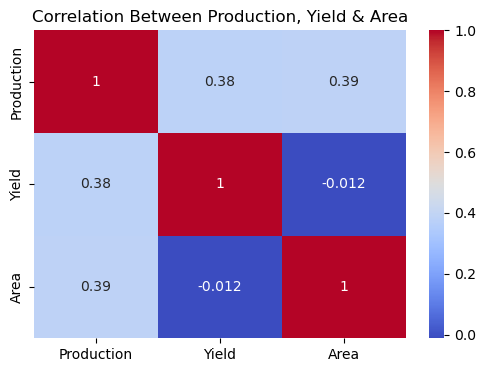

In [23]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['Production', 'Yield', 'Area']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Production, Yield & Area")
plt.show()
#Correlation heatmap to see if high production is due to high yield or large area.

# SECTION-D: Tableau Dashboard

- Maps: state-wise production or yield color-coded
- Time-series charts for yield over years by crop/state
- Heatmap: crop vs state yield comparison
- Bar chart: top producing states for each crop
- KPI cards: highest yield, lowest variability, next predicted growth
- Seasonal comparison visuals: Kharif vs Rabi yield differences

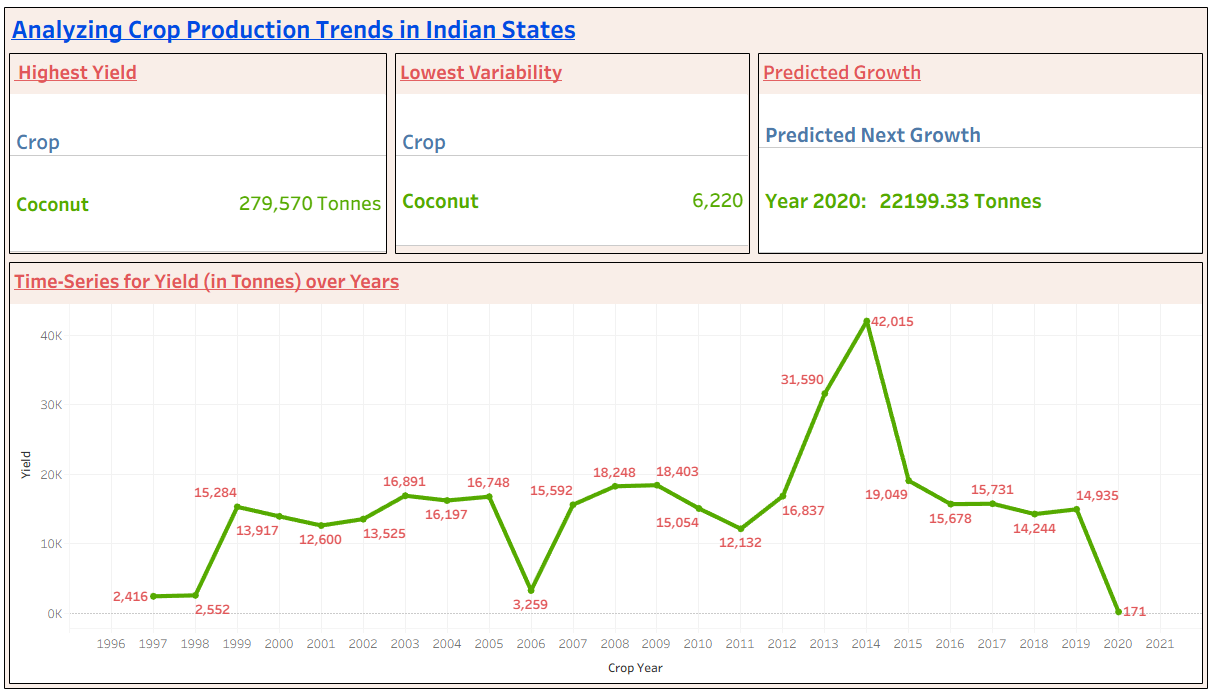

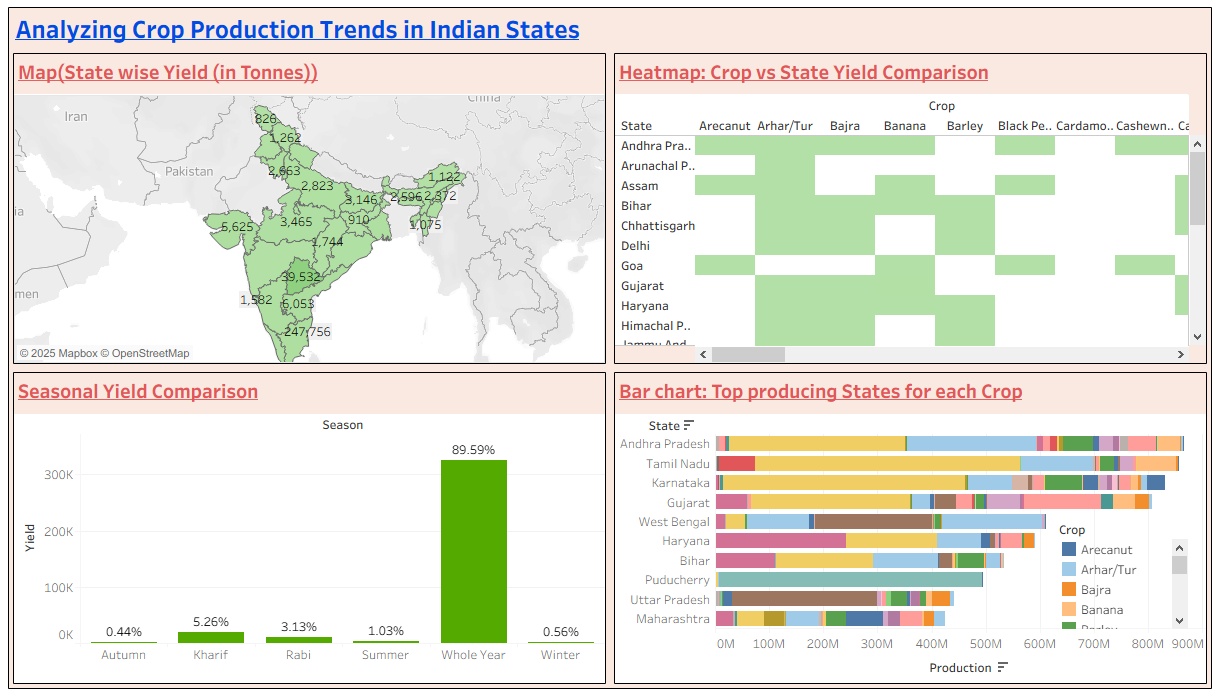

# SECTION-E: Machine Learning

## Regression Task:

#### - Forecast crop production (or yield) for selected state–crop based on historical data
#### - Models: Linear Regression, Random Forest Regressor, Gradient Boosting

#### We use Random Forest Regressor to predict the production because:

It's a robust and powerful model that:
- Handles non-linear data
- Reduces overfitting
- Works well with large datasets
- Does not give negative predictions, which is good for quantities like production

In [24]:
#These libraries are essential for data handling (pandas, numpy), ML model and evaluation.
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [25]:
from sklearn.preprocessing import LabelEncoder

le_crop = LabelEncoder()
le_state = LabelEncoder()
le_season = LabelEncoder()

df['Crop_Code'] = le_crop.fit_transform(df['Crop'])
df['State_Code'] = le_state.fit_transform(df['State'])
df['Season_Code'] = le_season.fit_transform(df['Season'])

#### Explanation:
What is happening?
- This code converts text labels like:
    "Rice", "Maize" → into numbers like 0, 1, etc.
    "Kharif", "Rabi" → into 0, 1, etc.
- It creates new columns: Crop_Code, State_Code, Season_Code.

Why is this done?
- Most ML models cannot work with text (like "Rice").
- Label Encoding converts these into numerical format.


In [26]:
from sklearn.model_selection import train_test_split

features = ['State_Code', 'Crop_Code', 'Crop_Year', 'Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Season_Code']
X = df[features]
y = df['Production']  
#X contains input features, and y is the target (Yield to predict).


#Splits the data into training and testing sets (80% train, 20% test) for unbiased evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Explanation:
What’s happening?
- X contains input features (independent variables).
- y is the target (what we want to predict): Production.
- The dataset is split into 80% for training and 20% for testing using train_test_split.

Why it's important?
- The training set is used to build the model.
- The test set checks how well the model works on unseen data (real-world simulation).

In [27]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [28]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print("R² Score:", r2)
print("RMSE:", rmse)

R² Score: 0.9221339504568017
RMSE: 529945.48525744


#### Explanation:
- y_pred: the predicted values for test data.
- r2_score: measures how well predictions match actual values. Closer to 1.0 is better.
- RMSE: tells the average error between actual and predicted values. Lower is better.

  In this Dataset, it is normal and acceptable for "Production" of RMSE, in which values are like:
- Min: 0
- Median: ~13,804
- Max: 6,326,000,000 (over 600 crore!)

In [29]:
#Predict for a new custom input
# Format: [State_Code, Crop_Code, Crop_Year, Area, Annual_Rainfall, Fertilizer, Pesticide, Season_Code]
sample = np.array([[1, 10, 2020, 15000, 1200, 5000, 300, 2]])  # Replace with your values
predicted_Production = model.predict(sample)[0]
print("Predicted Production:", predicted_Production)


Predicted Production: 9346.82


C:\Users\Shree\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Classification Task:

- Bin states as High-Yield, Medium-Yield, Low-Yield based on yield thresholds
- Features: historical yield, area, production variability, state, crop
- Models: Decision Tree, Random Forest, Logistic Regression
- Evaluate via accuracy, confusion matrix, feature importance

#### Let’s compare options:

- Logistic Regression: Simple, interpretable but Assumes linear separation and May underperform
- Decision Tree: Easy to understand, handles non-linearity but Prone to overfitting results Decent baseline
- Random Forest: Robust, handles non-linear data, better accuracy	but little Slower than Logistic/Tree but gives Best balance

#### We chose Random forest classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
def categorize_yield(y):
    if y < 1:
        return "Low"
    elif y < 3:
        return "Medium"
    else:
        return "High"
#Converts the numeric yield into 3 categories: Low, Medium, and High
df['Yield_Label'] = df['Yield'].apply(categorize_yield)


#### The continuous yield values are converted into three categories:
- Low if yield < 1
- Medium if 1 ≤ yield < 3
- High if yield ≥ 3

A new column Yield_Label is created for classification.

In [32]:
#Define features and target
X = df[['State_Code', 'Crop_Code', 'Crop_Year', 'Area', 'Annual_Rainfall',
        'Fertilizer', 'Pesticide', 'Season_Code']]
y = df['Yield_Label']

In [33]:
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
#stratify=y ensures all classes (Low/Medium/High) are balanced in train/test sets.

In [34]:
#Train the Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [35]:
#Evaluate the model
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        High       0.92      0.84      0.88       789
         Low       0.87      0.93      0.90      1862
      Medium       0.84      0.81      0.82      1209

    accuracy                           0.87      3860
   macro avg       0.88      0.86      0.87      3860
weighted avg       0.87      0.87      0.87      3860

Confusion Matrix:
 [[ 659   60   70]
 [  16 1724  122]
 [  40  190  979]]


#### Explanation:
- y_pred: predicted labels for the test data.
- classification_report: shows precision, recall, f1-score for each class.
- confusion_matrix: shows how many predictions were correct/incorrect for each class.
- Precision: How many predicted "High" are actually High?
- Recall: Out of all real High crops, how many did we find?
- F1 Score: A balance between precision and recall.

In [36]:
#Predict on a new custom input
#Format: 'State_Code', 'Crop_Code', 'Crop_Year', 'Area', 'Annual_Rainfall','Fertilizer', 'Pesticide', 'Season_Code'
sample = np.array([[1, 10, 2020, 15000, 1200, 5000, 300, 2]])  # Example input
prediction = clf.predict(sample.reshape(1, -1))[0]
print("Predicted Yield Category:", prediction)


Predicted Yield Category: Low


C:\Users\Shree\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
